# Plotting Drake Passage Transport in ACCESS-OM3

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [1]:
#The following cell must be in all notebooks!
# cb: for MC_25km_jra_iaf-1.0-beta-5165c0f8 needed to use `analysis3-26.02`. See: https://access-nri.zulipchat.com/#narrow/channel/470332-ocean-seaice/topic/OM3.20evaluation.20paper/near/572258756

In [2]:
#parameters

### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

# needed for mkmd START 
notebook_name='not_using_mkfigs.sh'
notebooks_dir = os.path.join(f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
from mkfigs_configdoc import mkmd,get_notebook_name
notebook_name=get_notebook_name(notebook_name)
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of another type.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
# needed for mkmd STOP

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

Changed working directory to: /g/data/tm70/cyb561/access-om3-paper-1/notebooks
Notebook name is: not_using_mkfigs.sh
ESM datastore path:  /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-figs/


In [3]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime


/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [4]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [5]:
#datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [6]:
umo_2d = datastore.search(variable="umo_2d").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Load ACCESS-OM2 data from ACCESS-NRI Catalog

In [7]:
catalog = intake.cat.access_nri

In [8]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='tx_trans_int_z',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
tx_trans_int_z=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Just to show the latitude I've picked ...

(-80.0, -40.0)

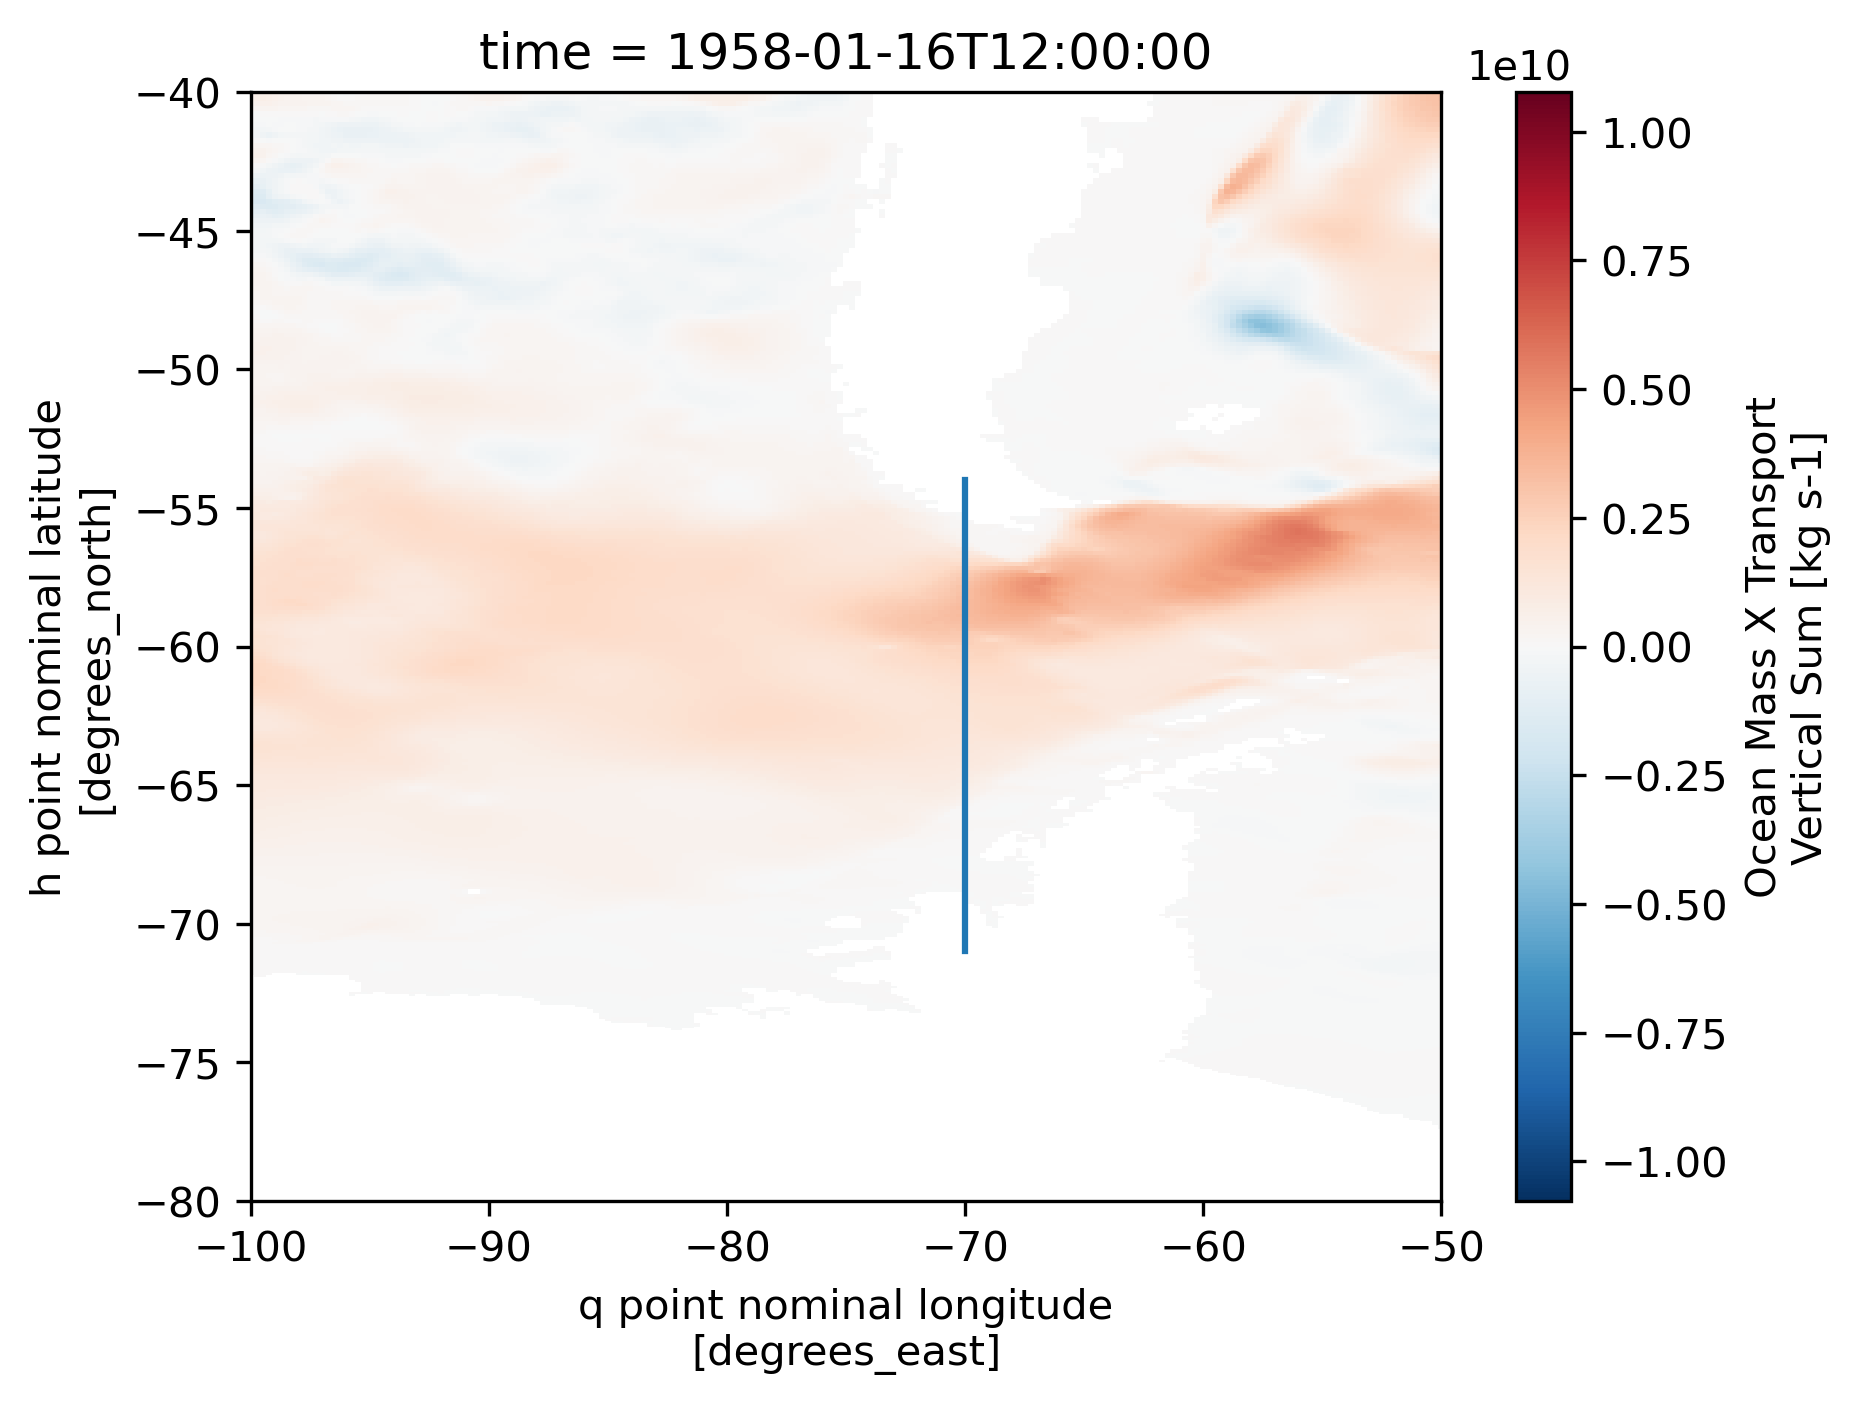

In [9]:
umo_2d["umo_2d"].isel(time=0).plot()
plt.plot([-70,-70],[-71,-54])
plt.xlim([-100,-50])
plt.ylim([-80,-40])

## Timeseries of DP Transport at -70°

In [10]:
DP_Trans_OM3 = umo_2d["umo_2d"].sel(xq=-70,method='nearest').sel(yh=slice(-71,-54)).sum("yh").load() / 1025 / 1e6

In [11]:
DP_Trans_OM2 = tx_trans_int_z["tx_trans_int_z"].sel(xu_ocean=-70,method='nearest').sel(yt_ocean=slice(-71,-54)).sum("yt_ocean").sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).load() / 1036 / 1e6

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.02/lib/python3.11/site-packages/xarray/plot/dataarray_plot.py:518: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


TypeError: tz must be string or tzinfo subclass, not ('noleap', 'days since 2000-01-01', <class 'cftime._cftime.DatetimeNoLeap'>).

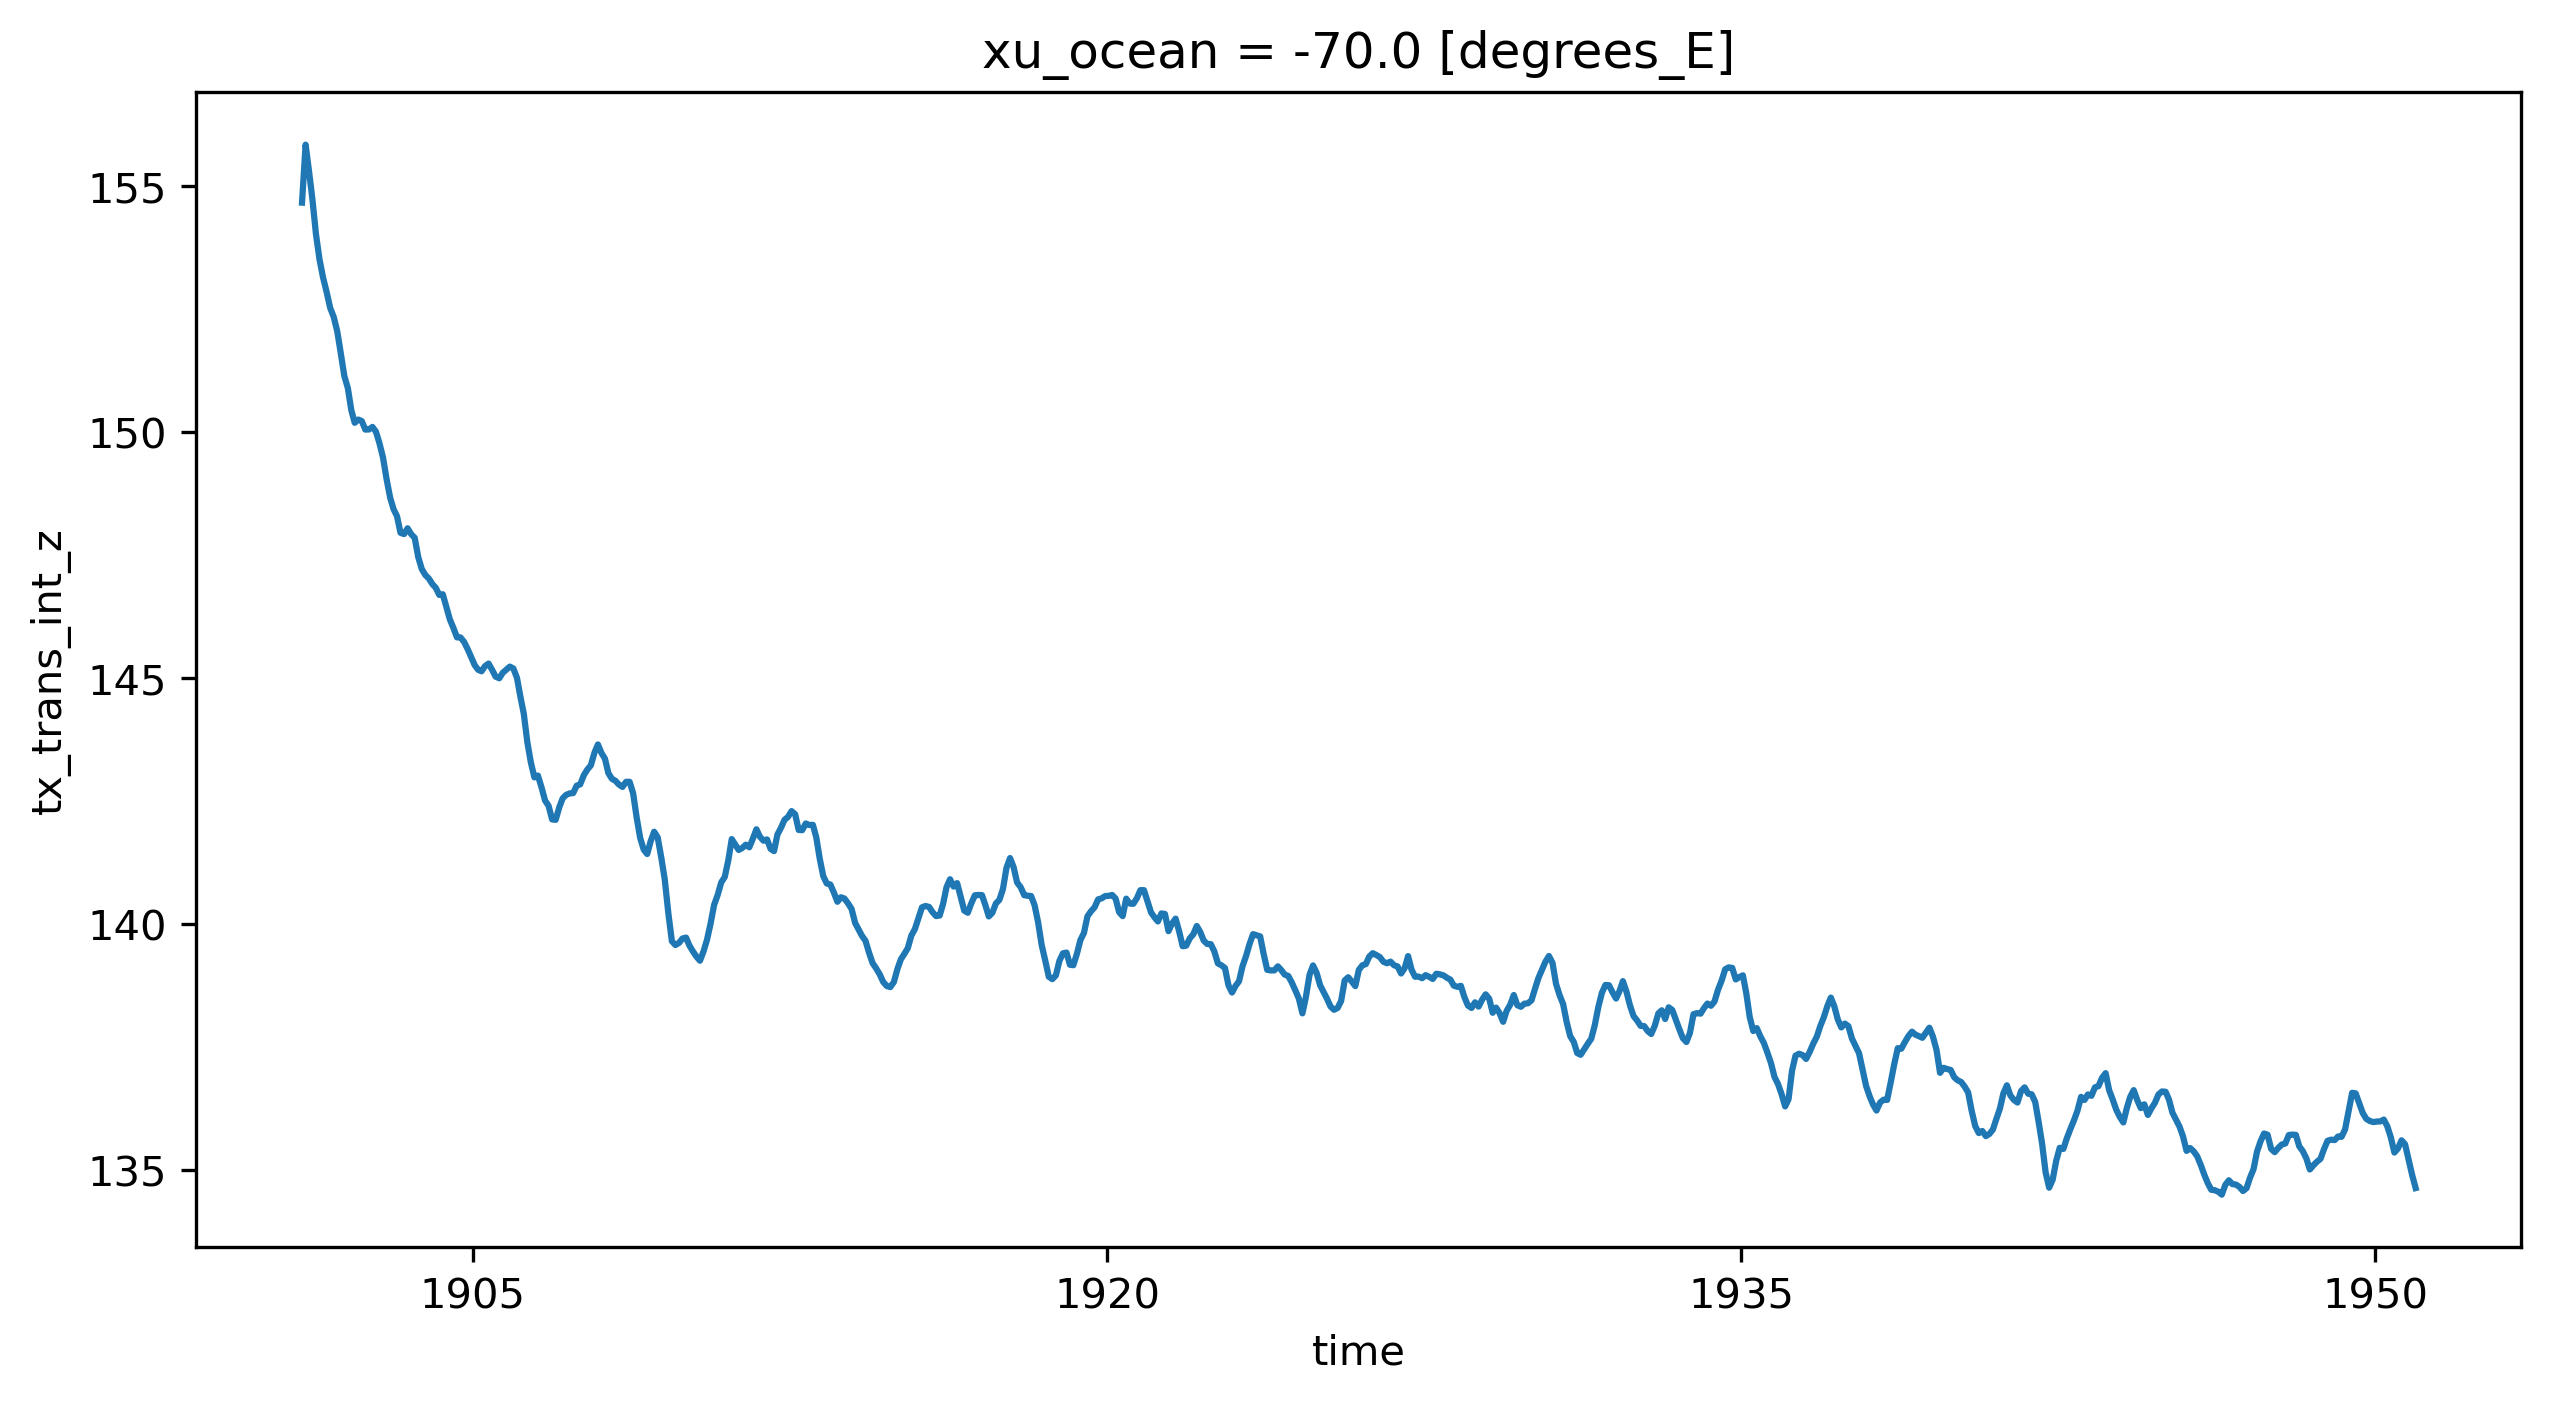

In [12]:
plt.figure(figsize=(10, 5)) 

DP_Trans_OM2.rolling(time=12).mean().plot(label='ACCESS-OM2')
DP_Trans_OM3.rolling(time=12).mean().plot(label='ACCESS-OM3')

plt.plot([cftime.datetime(1900, 1, 1), cftime.datetime(1950, 12, 31)], [173, 173],
           'k--', label="Donohue et al. (2016)")

plt.ylabel('Streamfunction (Sv)')
plt.title('Drake Passage Transport')
plt.legend()

plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')


In [ ]:



mkmd("Drake Passage Transport","`"+notebook_name+"`: Drake passage transport in ACCESS-OM3 and ACCESS-OM",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')


In [11]:
client.close()